# RAG + Llama 3 for a Harry Potter English Language Learning Assistant

Harry Potter, written by J.K. Rowling, is one of the most beloved series of all time, with rich language and intricate plots that captivate readers. Leveraging this series for educational purposes can motivate learners by immersing them in a familiar and enjoyable context.

Learning English, particularly as a second language, can be challenging and often lacks engaging and interactive methods. Traditional learning approaches may not capture the interest of learners, making it difficult for them to stay motivated and practice regularly. There's a need for an engaging, interactive tool that can provide instant feedback and make the learning process enjoyable.

We will use the Llama 3 open-source model using a dataset derived from the Harry Potter series to create a chatbot. This chatbot will ask users questions about Harry Potter, engaging them in conversations related to the movies. Additionally, it will correct users' mistakes, providing explanations to enhance their learning experience. This interactive approach will not only make learning English more enjoyable but also provide practical language usage practice.

### Creating S3 bucket to store the dataset

In [1]:
!pip install gradio==3.42.0
!pip install chromadb==0.5.3
!pip install pydantic==1.10.11


  Using cached gradio-3.42.0-py3-none-any.whl.metadata (17 kB)
  Using cached aiofiles-23.2.1-py3-none-any.whl.metadata (9.7 kB)
  Using cached ffmpy-0.4.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached gradio_client-0.5.0-py3-none-any.whl.metadata (7.1 kB)
  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached python_multipart-0.0.9-py3-none-any.whl.metadata (2.5 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached websockets-11.0.3-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.6 kB)
Using cached gradio-3.42.0-py3-none-any.whl (20.1 MB)
Using cached gradio_client-0.5.0-py3-none-any.whl (298 kB)
Using cached aiofiles-23.2.1-py3-none-any.whl (15 kB)
Using cached semantic_version-2.10.0-py2.py3-none-any.whl (15 kB)
Using cached websockets-11.0.3-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (129 kB)
U

In [2]:
import sagemaker
import boto3

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
# Create an S3 client
s3 = boto3.client('s3')

# Get the SageMaker execution role
role = sagemaker.get_execution_role()

In [4]:
bucket_name = 'harry-potter-books'

In [5]:
region = boto3.Session().region_name

s3.create_bucket(Bucket=bucket_name)

{'ResponseMetadata': {'RequestId': 'BMVZTP9VD8S8B3SJ',
  'HostId': 'FswReZ2z1C7JEFNiMUqtFKGKImuf1s3JfKMoShBGVredSEQ0O0aSsUnKzi56lXBQYwBVxtMdp9s=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'FswReZ2z1C7JEFNiMUqtFKGKImuf1s3JfKMoShBGVredSEQ0O0aSsUnKzi56lXBQYwBVxtMdp9s=',
   'x-amz-request-id': 'BMVZTP9VD8S8B3SJ',
   'date': 'Sun, 01 Sep 2024 16:22:39 GMT',
   'location': '/harry-potter-books',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'Location': '/harry-potter-books'}

### Download files and add them to the newly created bucket

In [6]:
import requests
import os

# List of files to download from the GitHub repository
files = [
    "book1.txt",
    "book2.txt",
    "book3.txt",
    "book4.txt",
    "book5.txt",
    "book6.txt",
    "book7.txt"
]

# Base URL for the GitHub repository raw files
base_url = "https://raw.githubusercontent.com/khushmeeet/potter-nlp/master/final_data/"


for file_name in files:
    # Construct the full URL for the file
    file_url = base_url + file_name

    # Step 1: Download the file from GitHub
    response = requests.get(file_url)
    if response.status_code == 200:
        with open(file_name, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {file_name}")
    else:
        print(f"Failed to download {file_name}. Status code: {response.status_code}")
        continue

    # Step 2: Upload the file to the S3 bucket
    s3_file_key = file_name
    try:
        s3.upload_file(file_name, bucket_name, s3_file_key)
        print(f"Uploaded {file_name} to s3://{bucket_name}/{s3_file_key}")
    except Exception as e:
        print(f"Error uploading {file_name}: {e}")

    # Clean up the local file
    os.remove(file_name)

print("All files processed.")


Downloaded book1.txt
Uploaded book1.txt to s3://harry-potter-books/book1.txt
Downloaded book2.txt
Uploaded book2.txt to s3://harry-potter-books/book2.txt
Downloaded book3.txt
Uploaded book3.txt to s3://harry-potter-books/book3.txt
Downloaded book4.txt
Uploaded book4.txt to s3://harry-potter-books/book4.txt
Downloaded book5.txt
Uploaded book5.txt to s3://harry-potter-books/book5.txt
Downloaded book6.txt
Uploaded book6.txt to s3://harry-potter-books/book6.txt
Downloaded book7.txt
Uploaded book7.txt to s3://harry-potter-books/book7.txt
All files processed.


### Now that the files are in our own bucket, we download them to the local instance

In [7]:
# Local directory to save the downloaded files
local_directory = "harry_potter_books/"  # Replace with your desired local directory

# Create the local directory if it doesn't exist
os.makedirs(local_directory, exist_ok=True)

# Initialize S3 client
s3 = boto3.client('s3')

for file_name in files:
    # Full S3 path to the file
    s3_file_key = file_name

    # Full local path to save the file
    local_file_path = os.path.join(local_directory, file_name)

    # Download the file from S3
    try:
        s3.download_file(bucket_name, s3_file_key, local_file_path)
        print(f"Downloaded {file_name} to {local_file_path}")
    except Exception as e:
        print(f"Error downloading {file_name}: {e}")

print("All files downloaded.")

Downloaded book1.txt to harry_potter_books/book1.txt
Downloaded book2.txt to harry_potter_books/book2.txt
Downloaded book3.txt to harry_potter_books/book3.txt
Downloaded book4.txt to harry_potter_books/book4.txt
Downloaded book5.txt to harry_potter_books/book5.txt
Downloaded book6.txt to harry_potter_books/book6.txt
Downloaded book7.txt to harry_potter_books/book7.txt
All files downloaded.


In [8]:
def process_files(files):
    all_content = ""  # Variable to store the concatenated content
    
    for file_path in files:
        local_file_path = os.path.join(local_directory, file_path)
        with open(local_file_path, 'r') as file:
            content = file.read()

        section = content[:100]

        print(f"Contents of {local_file_path}:")
        print(len(content))
        print(section)
        print("\n" + "="*50 + "\n")  # Separator for clarity
        all_content += content

    return all_content

# Process the list of files
all_content = process_files(files)
len(all_content)

Contents of harry_potter_books/book1.txt:
430856
the boy who lived mr. and mrs. dursley of number four privet drive were proud to say that they were 


Contents of harry_potter_books/book2.txt:
483764
j . k . r o w l ! n g harry potter the worst birthday not for the first time an argument had broken 


Contents of harry_potter_books/book3.txt:
614926
owl post harry potter was a highly unusual boy in many ways. for one thing he hated the summer holid


Contents of harry_potter_books/book4.txt:
1084930
the riddle house the villagers of little hangleton still called it “the riddle house,” even though i


Contents of harry_potter_books/book5.txt:
1466097
harry potter i dudley demented the hottest day of the summer so far was drawing to a close and a dro


Contents of harry_potter_books/book6.txt:
965468
 j the other minister it was nearing midnight and the prime minister was sitting alone in his office


Contents of harry_potter_books/book7.txt:
1118586
i  the dark lord ascending the two m

6164627

## Data Exploration

In [22]:
!pip install nltk 
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[nltk_data] Downloading package punkt to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Total Number of Words: 1327660
Number of Unique Words: 24740
Total Number of Sentences: 60028
Average Sentence Length: 22.12 words


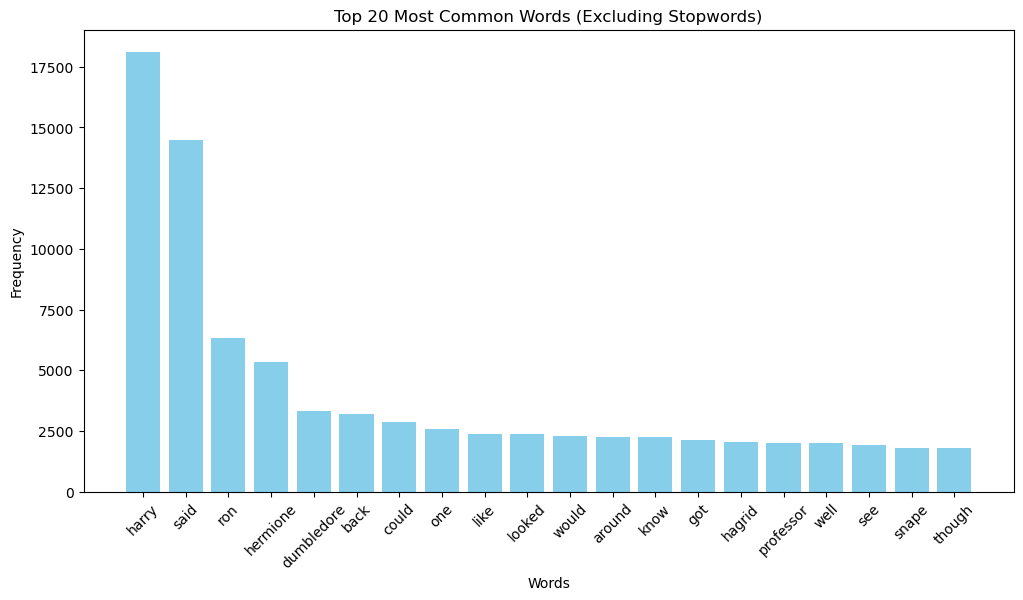

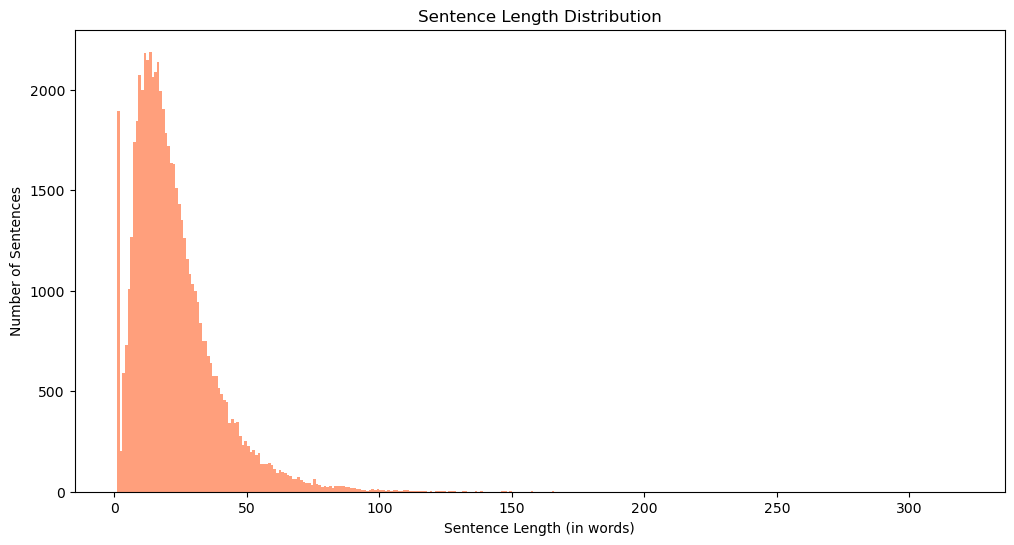

In [23]:
import os
import nltk
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

# Ensure NLTK data is downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Path to the directory containing the Harry Potter book text files
books_dir = local_directory

# Initialize variables for analysis
total_words = 0
unique_words = set()
total_sentences = 0
sentence_lengths = []
all_words = []

# Stop words for filtering common English words
stop_words = set(stopwords.words('english'))

# Process each book
for filename in os.listdir(books_dir):
    if filename.endswith(".txt"):
        filepath = os.path.join(books_dir, filename)
        with open(filepath, 'r', encoding='utf-8') as file:
            text = file.read()

            # Tokenize text into words and sentences
            words = word_tokenize(text)
            sentences = sent_tokenize(text)

            # Update word and sentence counts
            total_words += len(words)
            unique_words.update(words)
            total_sentences += len(sentences)
            sentence_lengths.extend([len(word_tokenize(sent)) for sent in sentences])
            all_words.extend(words)

# Filter out punctuation and stopwords from word list
filtered_words = [word.lower() for word in all_words if word.isalpha() and word.lower() not in stop_words]

# Word frequency distribution
word_freq = Counter(filtered_words)
most_common_words = word_freq.most_common(20)

# Calculate statistics
average_sentence_length = sum(sentence_lengths) / len(sentence_lengths) if sentence_lengths else 0

# Print results
print(f"Total Number of Words: {total_words}")
print(f"Number of Unique Words: {len(unique_words)}")
print(f"Total Number of Sentences: {total_sentences}")
print(f"Average Sentence Length: {average_sentence_length:.2f} words")

# Visualizations
# 1. Word Frequency Distribution (Top 20 words)
plt.figure(figsize=(12, 6))
words, counts = zip(*most_common_words)
plt.bar(words, counts, color='skyblue')
plt.title("Top 20 Most Common Words (Excluding Stopwords)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

# 2. Sentence Length Distribution
plt.figure(figsize=(12, 6))
plt.hist(sentence_lengths, bins=range(1, max(sentence_lengths) + 1), color='coral', alpha=0.75)
plt.title("Sentence Length Distribution")
plt.xlabel("Sentence Length (in words)")
plt.ylabel("Number of Sentences")
plt.show()


## RAG Implementation
### We split the books content into smaller chunks

In [9]:
!pip install --upgrade langchain
!pip install spaces

  Using cached langchain-0.2.15-py3-none-any.whl.metadata (7.1 kB)
  Using cached langchain_core-0.2.37-py3-none-any.whl.metadata (6.2 kB)
  Using cached langchain_text_splitters-0.2.2-py3-none-any.whl.metadata (2.1 kB)
Using cached langchain-0.2.15-py3-none-any.whl (1.0 MB)
Using cached langchain_core-0.2.37-py3-none-any.whl (396 kB)
Using cached langchain_text_splitters-0.2.2-py3-none-any.whl (25 kB)
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.1.52
    Uninstalling langchain-core-0.1.52:
      Successfully uninstalled langchain-core-0.1.52
  Attempting uninstall: langchain
    Found existing installation: langchain 0.1.9
    Uninstalling langchain-0.1.9:
      Successfully uninstalled langchain-0.1.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-ai-magics 2.18.1 requires langchain<0.2.0,>=0.1.0, but you h

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document

splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=0)
chunks = splitter.split_text(all_content)

# Create Document objects from the chunks
documents = [Document(page_content=chunk) for chunk in chunks]

# Print the Document objects (or process them further)
for i, doc in enumerate(documents[:5]):
    print(f"Document {i + 1}:\n{doc.page_content}\n")

Document 1:
the boy who lived mr. and mrs. dursley of number four privet drive were proud to say that they were perfectly normal thank you very much. they were the last people you’d expect to be involved in anything strange or mysterious because they just didn’t hold with such nonsense. mr. dursley was the director of a firm called grunnings which made drills. he was a big beefy man with hardly any neck although he did have a very large mustache. mrs. dursley was thin and blonde and had nearly twice the usual amount of neck which came in very useful as she spent so much of her time craning over garden fences spying on the neighbors. the dursley s had a small son called dudley and in their opinion there was no finer boy anywhere. the dursleys had everything they wanted but they also had a secret and their greatest fear was that somebody would discover it. they didn’t think they could bear it if anyone found out about the potters. mrs. potter was mrs. dursley’s sister but they hadn’t met

## We use ChromaDB as our vector DB

In [11]:
import chromadb

client = chromadb.Client()

In [12]:
COLLECTION_NAME = 'harry_potter_books'

collection = client.create_collection(name=COLLECTION_NAME)

### Adding the documents to a collection will automatically create their embeddings

In [13]:
docs_text = [doc.page_content for doc in documents]

collection.add(
    ids=[str(i) for i in range(0, len(documents))],
    documents=docs_text,
)

In [14]:
NUMBER_OF_RESULTS = 2 # how many results to return

query = collection.query(
    query_texts=["dark arts"], # Chroma will embed this for us
    n_results=NUMBER_OF_RESULTS 
)
print(query)

{'ids': [['556', '1219']], 'distances': [[1.1539548635482788, 1.1884044408798218]], 'metadatas': [[None, None]], 'embeddings': None, 'documents': [['against the dark arts lesson we’ve ever had wasn’t it?” said ron excitedly as they made their way back to the classroom to get their bags. “he seems like a very good teacher,” said hermione approvingly. “but i wish i could have had a turn with the boggart — ” “what would it have been for you?” said ron sniggering. “a piece of homework that only got nine out of ten?” d flight of the fat lady in no time at all defense against the dark arts had become most people’s favorite class. only draco malfoy and his gang of slytherins had anything bad to say about professor lupin. “look at the state of his robes,” malfoy would say in a loud whisper as professor lupin passed. “he dresses like our old house-elf.” but no one else cared that professor lupin’s robes were patched and frayed. his next few lessons were just as interesting as the first. after b

In [15]:
results = query['documents'][0]

for result in results:
    print(result)
    print("\n ---------------------------- \n")

against the dark arts lesson we’ve ever had wasn’t it?” said ron excitedly as they made their way back to the classroom to get their bags. “he seems like a very good teacher,” said hermione approvingly. “but i wish i could have had a turn with the boggart — ” “what would it have been for you?” said ron sniggering. “a piece of homework that only got nine out of ten?” d flight of the fat lady in no time at all defense against the dark arts had become most people’s favorite class. only draco malfoy and his gang of slytherins had anything bad to say about professor lupin. “look at the state of his robes,” malfoy would say in a loud whisper as professor lupin passed. “he dresses like our old house-elf.” but no one else cared that professor lupin’s robes were patched and frayed. his next few lessons were just as interesting as the first. after boggarts they studied red caps nasty little goblinlike creatures that lurked wherever there had been bloodshed in the dungeons of castles and the poth

In [16]:
def search(query: str, k: int = 3):
    """a function that embeds a new query and returns the most probable results"""

    query = collection.query(
      query_texts=[query],
      n_results=k
    )

    results = query['documents'][0]

    return results

## Deploying Llama 3 Model

### We will use models from Hugging Face, so we first authenticate using our HF Token

In [17]:
from huggingface_hub import notebook_login
notebook_login()

### We use HuggingFaceModel to deploy to it to an AWS Endpoint instance

In [17]:
from sagemaker.huggingface.model import HuggingFaceModel
from sagemaker.huggingface import HuggingFaceModel, get_huggingface_llm_image_uri

HF_TOKEN = "" # TODO - ADD YOUR OWN TOKEN

instance_type = "ml.g5.2xlarge"
health_check_timeout = 600
initial_instance_count = 1
MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
# Hub Model configuration. https://huggingface.co/models
config = {
 'HF_MODEL_ID':MODEL_NAME,
 'MESSAGES_API_ENABLED': "true", # Enable the messages API
 'MAX_BATCH_TOTAL_TOKENS': "8192",  # Limits the number of tokens that can be processed in parallel during the generation
 'HUGGING_FACE_HUB_TOKEN': HF_TOKEN
}

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
 image_uri=get_huggingface_llm_image_uri("huggingface",version="1.4.2"),
 env=config,
 role=role, 
)

# deploy model to SageMaker Inference
predictor = huggingface_model.deploy(
 initial_instance_count=initial_instance_count,
 instance_type=instance_type,
 container_startup_health_check_timeout=health_check_timeout,
)

------------!

### Now, that the model is deployed, we will setup the UI interface using Gradio spaces

In [18]:
!pip install spaces
from transformers import TextIteratorStreamer
from threading import Thread
import spaces
import gradio as gr

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [36]:
SYS_PROMPT = """You are a language learning assistant. You are engaging in a conversation with me about Harry Potter to help me practice 
my English language skills. Correct me whenever I make a grammar or vocabulary mistake.
Keep the conversation flowing by always asking a question that will help me practice.
Ask me 10 questions and then end the conversation.

After the first interaction, you will receive a passage from one of the books. Use the provided context to guide the rest of the conversation. Do not mention the
passage in the conversation, just use it as context to ensure accurate and contextually relevant interactions."""

In [24]:
ENDPOINT_NAME="huggingface-pytorch-tgi-inference-2024-09-01-16-29-42-613"

In [42]:
import gradio as gr
import boto3
import json

runtime = boto3.client('sagemaker-runtime')

retrieved_text = ""

def talk(prompt, history=[]):
    global retrieved_text
    
    # If history is empty, it means this is the first interaction
    if not history:
        initial_question = "Hey! What is the thing you most like about Harry Potter?"
        return initial_question 
    
    if len(history) == 1:        
        # Retrieve relevant documents using the RAG system based on the user's response
        retrieved_docs = search(prompt, k=1)
        retrieved_text = "\n\n".join(retrieved_docs)
    
    final_prompt = f"{prompt}\n\nRetrieved Documents:\n{retrieved_text}"

    messages = [{"role": "system", "content": SYS_PROMPT}] 

    # Add previous conversation history
    for user_msg, bot_msg in history[:-1]:  # Exclude last entry since it's the context
        messages.append({"role": "user", "content": user_msg})
        messages.append({"role": "assistant", "content": bot_msg})
    
    messages.append({"role": "user", "content": final_prompt})

    # Generation arguments
    parameters = {
        "model": "Meta-Llama-3-8B-Instruct",  # Placeholder, needed
        "top_p": 0.6,
        "temperature": 0.9,
        "max_tokens": 512,
        "stop": [""]
    }

    # Prepare payload for the endpoint
    payload = {
        "messages": messages,
        **parameters
    }
    print(payload)

    # Invoke the endpoint
    response = runtime.invoke_endpoint(
        EndpointName=ENDPOINT_NAME,
        ContentType='application/json',
        Body=json.dumps(payload)
    )

    result = json.loads(response['Body'].read().decode())
    response_text = result["choices"][0]["message"]["content"].strip()

    print("Response Text:")
    print(response_text)

    # Append the bot's response to the history
   # history.append((prompt, response_text))

    return response_text 


TITLE = "Harry Potter Chatbot"

DESCRIPTION = """
An English learning chatbot using Meta-Llama-3-8B-Instruct
"""

demo = gr.ChatInterface(
    fn=talk,
    chatbot=gr.Chatbot(
        height=700,
        show_label=True,
        show_share_button=True,
        show_copy_button=True,
        bubble_full_width=False,
    ),
    theme="Soft",
    examples=[[]],
    title=TITLE,
    description=DESCRIPTION,
)

demo.launch(debug=True, inline=True)

Running on local URL:  http://127.0.0.1:7860
Sagemaker notebooks may require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

IMPORTANT: You are using gradio version 3.42.0, however version 4.29.0 is available, please upgrade.
--------
Running on public URL: https://ecbf041806685b101b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


{'messages': [{'role': 'system', 'content': 'You are a language learning assistant. You are engaging in a conversation with me about Harry Potter to help me practice \nmy English language skills. Correct me whenever I make a grammar or vocabulary mistake.\nKeep the conversation flowing by always asking a question that will help me practice.\nAsk me 10 questions and then end the conversation.\n\nAfter the first interaction, you will receive a passage from one of the books. Use the provided context to guide the rest of the conversation. Do not mention the\npassage in the conversation, just use it as context to ensure accurate and contextually relevant interactions.'}, {'role': 'user', 'content': "The Marauder's map\n\nRetrieved Documents:\nyears could hear him and told them all about the marauder’s map. “how come fred and george never gave it to me!” said ron outraged. “i’m their brother!” “but harry isn’t going to keep it!” said hermione as though the idea were ludicrous. “he’s going to

In [43]:
SYS_PROMPT_LLM = "You are a helpful assistant. Give me an accurate answer to the given prompt. Don't invent the answer if you don't know it, simply say that you don't know."
SYS_PROMPT_RAG = "You are a helpful assistant. You will be given a prompt and a context. Use the provided context from the relevant documents to answer the question. Base your responses on this context to ensure accurate and contextually relevant answers."

# Define the function
def get_response(prompt, is_rag=False):
    # Select the system prompt based on whether it's RAG or not
    if is_rag:
        sys_prompt = SYS_PROMPT_RAG
        retrieved_docs = search(prompt, k=1)
        retrieved_text = "\n\n".join(retrieved_docs)
        prompt = f"{prompt}\n\nRetrieved Documents:\n{retrieved_text}"                
    else:
        sys_prompt = SYS_PROMPT_LLM
    
    messages = [{"role": "system", "content": sys_prompt}]
    messages.append({"role": "user", "content": prompt})

    # Generation parameters
    parameters = {
        "model": "Meta-Llama-3-8B-Instruct",  # Placeholder, use the actual model name
        "top_p": 0.6,
        "temperature": 0.9,
        "max_tokens": 512,
        "stop": [""]
    }

    payload = {
        "messages": messages,
        **parameters
    }

    # Invoke the endpoint
    response = runtime.invoke_endpoint(
        EndpointName=ENDPOINT_NAME,
        ContentType='application/json',
        Body=json.dumps(payload)
    )

    # Parse the response
    result = json.loads(response['Body'].read().decode())
    response_text = result["choices"][0]["message"]["content"].strip()

    return response_text

# Example usage
prompt = "Who is Aunt Petunia? What happens when she receives a letter to her doorstep? Give me extra details"
is_rag = False 
response = get_response(prompt, is_rag=is_rag)
print(f"Response: {response}")

Response: Aunt Petunia is a character from the beloved Harry Potter book series by J.K. Rowling. She is the aunt of Harry Potter, the main protagonist, and the wife of Uncle Vernon Dursley. Aunt Petunia is a rather unpleasant and cruel person who treats Harry poorly, along with her husband and son Dudley.

In the story, Aunt Petunia receives a letter addressed to Harry Potter at her doorstep, which is a significant event in the series. The letter is from Hogwarts School of Witchcraft and Wizardry, informing Harry that he has been accepted to attend the school as a first-year student.

When Aunt Petunia receives the letter, she is shocked and upset, as she has been trying to keep Harry's true identity as a wizard a secret. She is worried that the letter will reveal their secret to the rest of the Dursleys and their neighbors. Aunt Petunia tries to hide the letter and prevent Harry from receiving it, but ultimately, Harry discovers it and learns the truth about his past and his connectio

## Evaluation

In [44]:
prompts = [
    "Describe the events leading up to and the outcome of the first Quidditch match in 'Harry Potter and the Philosopher's Stone'. Who are the key players, and what strategies do they use?",
    "Explain the significance of the Sorting Hat ceremony in 'Harry Potter and the Philosopher's Stone'. How does the Sorting Hat decide which house a student belongs to, and what factors are considered?",
    "In 'Harry Potter and the Chamber of Secrets', what clues lead Harry and his friends to discover the location of the Chamber of Secrets? How do they ultimately uncover the identity of the heir of Slytherin?",
    "Detail the events that occur during the Yule Ball in 'Harry Potter and the Goblet of Fire'. How do the characters prepare for the ball, and what are the major highlights and conflicts that arise during the event?",
    "What are the main differences between the Marauder's Map and the Invisibility Cloak in terms of their magical properties and uses in 'Harry Potter and the Prisoner of Azkaban'? How do Harry and his friends utilize these items?",
    "Describe the interactions between Harry Potter and Severus Snape during the scenes set in 'Harry Potter and the Half-Blood Prince'. How does their relationship evolve, and what key events influence their interactions?",
    "In 'Harry Potter and the Order of the Phoenix', how does the formation of Dumbledore's Army (DA) impact the students of Hogwarts? What are the objectives of the DA, and how do they prepare for the challenges they face?",
    "What is the significance of the prophecy revealed in 'Harry Potter and the Order of the Phoenix'? How does the prophecy affect Harry's understanding of his own role in the fight against Voldemort?",
    "Detail the final battle between Harry Potter and Voldemort in 'Harry Potter and the Deathly Hallows'. What are the key moments of the battle, and how do the various characters contribute to the final confrontation?",
    "In 'Harry Potter and the Prisoner of Azkaban', explain the role of the Time-Turner in the story. How does Hermione Granger use it to alter events, and what are the consequences of its use on the overall plot?"
]

def get_responses(prompts, is_rag):
    responses = []
    for prompt in prompts:
        responses.append(get_response(prompt, is_rag=is_rag))
    return responses

# Obtain responses from RAG and LLM systems
rag_responses = get_responses(prompts, is_rag=True)
llm_responses = get_responses(prompts, is_rag=False)

# Print each prompt, followed by RAG and LLM responses
for prompt, rag_response, llm_response in zip(prompts, rag_responses, llm_responses):
    print(f"Prompt: {prompt}")
    print(f"RAG Response: {rag_response}")
    print(f"LLM Response: {llm_response}")
    print("-" * 50)


Prompt: Describe the events leading up to and the outcome of the first Quidditch match in 'Harry Potter and the Philosopher's Stone'. Who are the key players, and what strategies do they use?
RAG Response: The first Quidditch match in 'Harry Potter and the Philosopher's Stone' is between Gryffindor and Slytherin, and it takes place in November. The key players involved are Harry Potter, the Gryffindor Seeker, and his teammates, as well as the Slytherin team.

The events leading up to the match are significant, as Harry has been training extensively with his Quidditch coach, Madam Hooch, and his teammates, but his identity as the Seeker has been kept secret by his team captain, Oliver Wood. However, the news of Harry's involvement in the match has leaked out, and he is anxious about how he will perform.

On the day of the match, the weather is cold and icy, with the Quidditch field covered in frost. Hagrid is seen defrosting broomsticks, and the atmosphere is tense. Gryffindor is determ

In [45]:
from transformers import AutoTokenizer
from nltk.translate.bleu_score import sentence_bleu

tokenizer = AutoTokenizer.from_pretrained('meta-llama/Meta-Llama-3-8B-Instruct')

references = [
    ["The first Quidditch match in 'Harry Potter and the Philosopher's Stone' takes place between Gryffindor and Slytherin. Gryffindor's team includes Harry Potter as Seeker, Oliver Wood as Keeper, and Katie Bell, Angelina Johnson, and Alicia Spinnet as Chasers. Slytherin's team features Draco Malfoy as Seeker and Marcus Flint as Chaser. Gryffindor plays with aggressive tactics, utilizing their Beaters, Fred and George Weasley, to disrupt Slytherin's play. Harry catches the Golden Snitch after a dramatic chase, securing a victory for Gryffindor."],
    ["The Sorting Hat ceremony in 'Harry Potter and the Philosopher's Stone' is a crucial event that determines the house placement for first-year students at Hogwarts. The Sorting Hat, an enchanted hat with the ability to read the thoughts and qualities of students, sorts them into Gryffindor, Ravenclaw, Slytherin, or Hufflepuff based on traits such as bravery, intelligence, ambition, and loyalty. The Hat also considers the student's preferences and aspirations, ensuring that each student is placed in a house that aligns with their personality and potential."],
    ["In 'Harry Potter and the Chamber of Secrets,' several clues lead Harry and his friends to uncover the Chamber of Secrets' location. They follow the mysterious attacks on students, the petrification of Mrs Norris, and the diary of Tom Riddle. Moaning Myrtle's bathroom becomes a key location as it is revealed to be the entrance to the Chamber. By deciphering the diary's messages and understanding the history of Salazar Slytherin, they discover that the heir of Slytherin is Tom Riddle, who is Voldemort's younger self."],
    ["The Yule Ball in 'Harry Potter and the Goblet of Fire' is a formal event held during the Triwizard Tournament. Students prepare by selecting formal attire and finding dates. Harry Potter attends with Parvati Patil, while Ron Weasley goes with Padma Patil. Major highlights of the ball include the elaborate decorations, the dancing, and the emotional tension among characters. Ron feels jealous of Hermione's date, Viktor Krum, while Harry and his friends navigate social dynamics and conflicts that arise during the evening."],
    ["In 'Harry Potter and the Prisoner of Azkaban,' the Marauder's Map and the Invisibility Cloak have distinct magical properties. The Marauder's Map shows the entire layout of Hogwarts, including hidden passages and the locations of people within the castle. It is used by Harry and his friends to navigate and avoid detection. The Invisibility Cloak, passed down through Harry's family, renders the wearer invisible, allowing for stealthy movement. Hermione uses it to attend multiple classes and help Harry and Ron in crucial moments without being seen."],
    ["In 'Harry Potter and the Half-Blood Prince,' Harry Potter and Severus Snape have a strained relationship marked by distrust and conflict. Harry is suspicious of Snape's motives and his role in Draco Malfoy's activities. However, as the story progresses, Snape's true role as a double agent becomes apparent, and his relationship with Harry becomes more complex. Key events include Snape's protective actions and his eventual killing of Dumbledore, which reveals deeper layers to his character and his true allegiance."],
    ["In 'Harry Potter and the Order of the Phoenix,' Dumbledore's Army (DA) is formed as a response to the inadequate Defense Against the Dark Arts instruction under Dolores Umbridge. The DA, led by Harry Potter, aims to teach students practical defense skills and prepare them for real-world threats. The formation of the DA fosters a sense of solidarity among students, equips them with valuable magical knowledge, and builds their confidence. The group holds secret meetings, practices spells, and prepares for potential confrontations with dark forces."],
    ["The prophecy in 'Harry Potter and the Order of the Phoenix' is significant because it foretells that either Harry Potter or Voldemort must die at the hands of the other. The prophecy indicates that Voldemort's downfall is linked to Harry, suggesting that the final confrontation between them is inevitable. This revelation profoundly impacts Harry's understanding of his role in the fight against Voldemort, emphasizing his destiny and the responsibility he bears in the battle against dark forces."],
    ["The final battle between Harry Potter and Voldemort in 'Harry Potter and the Deathly Hallows' occurs at Hogwarts. Key moments include Voldemort's attacks on the castle, the duel in the Great Hall, and the destruction of the Horcruxes, which weakens Voldemort. Harry uses the Elder Wand, revealing its true allegiance, to defeat Voldemort. Various characters, including Hermione Granger, Ron Weasley, and members of the Order of the Phoenix, play crucial roles in the battle by fighting Death Eaters and protecting Hogwarts."],
    ["In 'Harry Potter and the Prisoner of Azkaban,' the Time-Turner is a magical device that allows Hermione Granger to travel back in time. Hermione uses the Time-Turner to attend multiple classes and, later, to help Harry rescue Sirius Black and Buckbeak. The use of the Time-Turner allows Hermione and Harry to intervene in key events, preventing Sirius's wrongful imprisonment and ensuring Buckbeak's safety. This device highlights the complexities of time travel and its impact on the plot, showcasing the potential consequences of altering events in the past."]
]

def compute_bleu_score(reference, response):
    reference_tokens = [tokenizer.tokenize(ref) for ref in reference]
    response_tokens = tokenizer.tokenize(response)
    return sentence_bleu(reference_tokens, response_tokens)


# Evaluate and compare BLEU scores
rag_bleu_scores = [compute_bleu_score(ref, resp) for ref, resp in zip(references, rag_responses)]
llm_bleu_scores = [compute_bleu_score(ref, resp) for ref, resp in zip(references, llm_responses)]

print(f"Average BLEU score for RAG: {sum(rag_bleu_scores) / len(rag_bleu_scores):.4f}")
print(f"Average BLEU score for LLM: {sum(llm_bleu_scores) / len(llm_bleu_scores):.4f}")


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Average BLEU score for RAG: 0.0960
Average BLEU score for LLM: 0.0912


In [27]:
#predictor.delete_endpoint()